In [1]:
%matplotlib inline
import os
import pickle
import h5py
import numpy as np
from matplotlib import pyplot as plt, ticker
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, writefile, utils as ut, plot as pp
from unwrap_error.simulation import iono
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]


box = (10, 55, 20, 70);   box_suffix = 'boxCL'   # box in the center left with low  altitude
#box = (85, 25, 145, 70);  box_suffix = 'boxCC'   # box to read for range offset in (x0, y0, x1, y1)
box = (200, 15, 215, 30); box_suffix = 'boxLR'   # box in the lower right with high altitude

proj_dir = '/Users/yunjunz/data/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

out_file = os.path.join(proj_dir, 'offset_comp', box_suffix ,'igs_tec.pickle')

# config for IGS TEC data
igs_tec_dir = os.path.expanduser('~/data/atmosphere/TEC')

Go to directory /Users/yunjunz/data/ChileSenAT149


### 1. calc/read IGS TEC data

In [2]:
## calculate ionospheric delay from IGS GNSS TEC
igs_tec_file = os.path.join(proj_dir, 'mintpyOffset/inputs/IGS_TEC.h5')

if not os.path.isfile(igs_tec_file):
    ref_ts_file = os.path.join(proj_dir, 'mintpyOffset/timeseriesRg.h5')
    geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')

    iono_file = iono.igs_iono_ramp_timeseries(igs_tec_dir,
                                              out_file=igs_tec_file,
                                              geom_file=geom_file,
                                              ref_ts_file=ref_ts_file)
else:
    print('file exists: {}, skip re-calculating.'.format(igs_tec_file))

## read data
atr = readfile.read_attribute(igs_tec_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
if box is None:
    box = (0, 0, width, length)
print('read delay with box {}'.format(box))
date_list = timeseries(igs_tec_file).get_date_list()
num_date = len(date_list)
with h5py.File(igs_tec_file, 'r') as f:
    ts_data = f['timeseries'][:, box[1]:box[3], box[0]:box[2]].reshape(num_date, -1)
    ts_vtec = f['vtec'][:]

# calculate median and mean
iono_avg = np.nanmean(ts_data, axis=-1)
iono_med = np.nanmedian(ts_data, axis=-1)

file exists: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/IGS_TEC.h5, skip re-calculating.
read delay with box (200, 15, 215, 30)


### 2. save to pickle file

In [3]:
# gather all into gim_tec dict
igs_tec = {}
igs_tec['date'] = np.array(date_list)
igs_tec['time'] = np.array(ptime.date_list2vector(date_list)[0])
igs_tec['TEC'] = np.array(ts_vtec)
igs_tec['range_delay4Cband_TEC'] = iono_med

## save to file
os.makedirs(os.path.dirname(out_file), exist_ok=True)
with open(out_file, 'wb') as f:
    pickle.dump(igs_tec, f)
    print('save data to file: {}'.format(out_file))

save data to file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/igs_tec.pickle


### 3. plot

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/../igs_tec.png


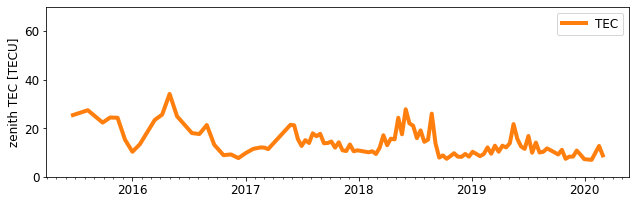

In [4]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(igs_tec['time'], igs_tec['TEC'], linewidth=4, color='C1', label='TEC')
pp.auto_adjust_xaxis_date(ax, igs_tec['time'], every_year=1, buffer_year=None)
ax.set_ylabel('zenith TEC [TECU]')
ax.set_ylim(0, 70)
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.legend()
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), '../igs_tec.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()